In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load(f):
    F = open(f,"r")
    out = []
    label = []
    for l in F:
        temp = [int(t) for t in l.split(",")]
        out.append(temp[1:])
        label.append(temp[0])
        
    return np.array(out),np.array(label)

train_data,train_label = load("./mnist_train.csv")
test_data,test_label = load("./mnist_test.csv")

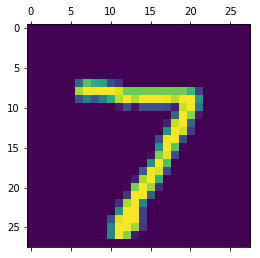

In [3]:
plt.matshow(np.reshape(test_data[0],[28,28]))
plt.show()

In [4]:
batch_size = 16
data_size = len(test_data[0])
data_edge = int(np.sqrt(data_size))
learning_rate = .001
n_epochs = 2000
n_labels = 10

rec_state_size = 32

In [5]:
m = np.mean(train_data)
s = np.std(train_data)

normed_data = (train_data - m)/s

In [6]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32,shape = (batch_size, data_size))
series = tf.transpose(tf.reshape(inputs,(-1,data_edge,data_edge)),[0,2,1])

labels = tf.placeholder(tf.float32,shape = (batch_size,10))

init_state = tf.zeros(shape = [rec_state_size])

In [7]:
def get_next_state(INP,STATE):
    net = tf.layers.dense(tf.concat([INP,STATE],axis = -1),128,name = "rnn_l1",reuse = tf.AUTO_REUSE,activation = tf.nn.relu)
    net = tf.layers.dense(net,STATE.shape[-1],name = "rnn_l2",reuse = tf.AUTO_REUSE)

    return net

state_out = [tf.tile(tf.expand_dims(init_state,0),(batch_size,1))]

for k in range(data_edge):
        state_out.append(get_next_state(series[:,k],state_out[-1]))
        
state_out = tf.stack(state_out,axis = 1)
print(state_out.shape)

flattened_state = tf.reshape(state_out,[-1,rec_state_size])
flattened_probs = tf.layers.dense(flattened_state,n_labels)
probs = tf.reshape(flattened_probs,[state_out.shape[0],state_out.shape[1],n_labels])

print(probs.shape)

(16, 29, 32)
(16, 29, 10)


In [8]:
test_time = 10

time_label = tf.tile(tf.expand_dims(labels,1),[1,probs.shape[1],1])
flattened_label = tf.reshape(time_label[:,-test_time:],[-1,n_labels])

flattened_probs = tf.reshape(probs[:,-test_time:],[-1,n_labels])
test_probs = tf.nn.softmax(probs,axis = -1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = flattened_label,logits = flattened_probs))

adam = tf.train.AdamOptimizer()
train = adam.minimize(loss)

In [9]:
def make_1hot(l):
    out = np.zeros(shape = (len(l),n_labels))
    for k in range(len(l)):
        out[k][l[k]] = 1
        
    return out

def MNIST_err(l,p):
    out = []
    for k in range(len(l)):
        if l[k][np.argmax(p[k])] == 1:
            out.append(1)
        else:
            out.append(0)
            
    return np.mean(out)

In [10]:
init = tf.global_variables_initializer()
config = tf.ConfigProto(device_count = {'GPU': 0})
sess = tf.Session(config=config)
sess.run(init)

In [11]:
results = []
print_freq = 100
test_freq = 100
normed_test = (test_data - m)/s
test_label_1h = make_1hot(test_label)

for k in range(n_epochs):
    b_index = np.random.choice(range(len(test_data)),batch_size,replace = False)
    batch_data = normed_data[b_index]
    batch_labels = make_1hot(train_label[b_index])
    
    _,train_loss = sess.run([train,loss],{inputs:batch_data,labels:batch_labels})

    if k%test_freq == 0:
        tres = []
        for j in range(len(normed_test)//16):
            tres.append(sess.run(loss,{inputs:normed_test[j*16:(j+1)*16],labels:test_label_1h[j*16:(j+1)*16]}))
                        
        tres = np.mean(tres)
        results.append([k,train_loss,tres])
                        
    if k%print_freq == 0:
        print("{}\t{}\t{}".format(k,train_loss,tres))
        
        
results = np.array(results)

0	2.3500781059265137	2.365145206451416
100	1.3480135202407837	1.9441105127334595
200	1.455082893371582	1.2143573760986328
300	1.0692535638809204	0.9749277234077454
400	0.6120018362998962	1.0617514848709106
500	0.7220198512077332	0.7644744515419006
600	0.5503047108650208	0.7142985463142395
700	0.5275874733924866	0.5242193341255188
800	0.36327117681503296	0.568606436252594
900	0.3863532543182373	0.5479476451873779
1000	0.9548435211181641	0.666864275932312
1100	0.48906785249710083	0.5418186783790588
1200	0.37183040380477905	0.4672691524028778
1300	0.6861201524734497	0.49960076808929443
1400	0.5095971822738647	0.726099967956543
1500	0.5296007394790649	0.5130217671394348
1600	0.5559536814689636	0.44114673137664795
1700	0.2509556710720062	0.43288710713386536
1800	0.16430184245109558	0.41309964656829834
1900	0.5874782800674438	0.5077965259552002


In [12]:
test = sess.run(test_probs,{inputs:normed_test[:16],labels:test_label_1h[:16]})
sess.close()

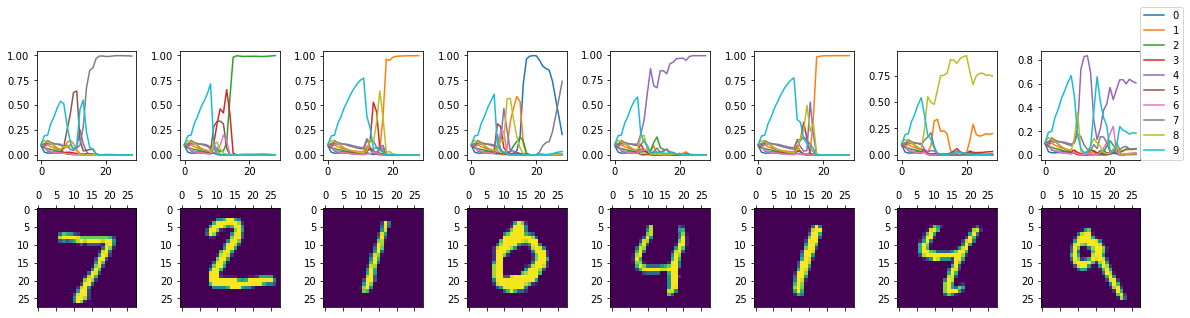

In [16]:
nfig = 8
fig,sub = plt.subplots(2,nfig,figsize = (nfig*2,4))

for ii in range(nfig):
    for kk in range(10):
        sub[0,ii].plot(test[ii,:,kk],label = kk)
    sub[1,ii].matshow(np.reshape(test_data[ii],[data_edge,data_edge]))

sub[0,-1].legend(loc = [1,0])
plt.tight_layout()
plt.show()